# Setup

In [2]:
import os
import io
from typing import Tuple, List, Dict

import numpy
import sklearn as sklearn
import torch
import tqdm as tqdm
from torch.nn import CrossEntropyLoss, BCELoss
from torch.optim import SGD
from torch.utils.data import Dataset

from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.datasets import ImageFolder
from IPython.display import display
import torchvision

from tqdm.notebook import tqdm
from torchvision.models import densenet161

from torch import nn

In [3]:
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# !gdown https://drive.google.com/uc?id=176kei7cLl-C5-E_t3amCfNYxugEqXhm3
!gdown https://drive.google.com/uc?id=18rSkvFIR-XrICnFoYVe4kz93UCiwKo4-

Downloading...
From: https://drive.google.com/uc?id=18rSkvFIR-XrICnFoYVe4kz93UCiwKo4-
To: /content/sentences.tgz
100% 686M/686M [00:06<00:00, 102MB/s] 


In [ ]:
!mkdir -p ../iamdataset/sentences-sample
!tar xzvf sentences.tgz -C ../iamdataset/sentences-sample

In [7]:
import importlib
from orientation_nn import OrientationImageFolder
import orientation_nn
importlib.reload(orientation_nn)
from orientation_nn import OrientationCNN

# %load_ext autoreload # %autoreload 1 # %aimport orientation_nn

In [8]:
# model = None
# load model from .pt
# model = OrientationCNN()
model = densenet161(pretrained=True)
# model.load_state_dict(torch.load("model-Densenet.1.pt"))


# for param in model.parameters():
    # param.requires_grad = False # freeze the pretrained part
# model.classifier = nn.Linear(2208,2)
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:02<00:00, 48.8MB/s]


In [9]:
dataset = OrientationImageFolder('../iamdataset/sentences-sample')

In [10]:
train_transform = transforms.Compose([
    # transforms.RandomCrop(224, padding=50),
    # transforms.RandomResizedCrop(112, scale=(0.08, 0.25)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.Resize(32), # (32, 256)),
    # orientation_nn.PadToSize((256,32), pad_with=999999), #LOL if you put "1" it will pad with 0.00392157 but if you put a really big number then it will work. Real bruh moment

    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation((180, 180)),
    # transforms.RandomInvert(p=1),
    # transforms.RandomInvert(p=1),
    orientation_nn.PadToSize((224,224), pad_with=255, center=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # get transforms from densenet161
    # torchvision.models.DenseNet161_Weights.DEFAULT.transforms()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])
# test_transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize(32), # (32, 256)),
#     orientation_nn.PadToSize((256,32), pad_with=999999), #LOL if you put "1" it will pad with 0.00392157 but if you put a really big number then it will work. Real bruh moment
#     transforms.RandomCrop((32, 256)),
#     # transforms.RandomInvert(p=0),
#     transforms.ToTensor()
# ])
dataset.transform = train_transform

# loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
from torch.utils.data import DataLoader


# test/train split
# prepare the dataset
def prepare_data(path):
    # define standardization
    # trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    # load dataset
    _datalen = len(dataset)
    _trainlen = int(_datalen * .8)
    train_set, test_set = torch.utils.data.random_split(dataset, [_trainlen, _datalen - _trainlen])

    # prepare data loaders
    train_dl = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
    test_dl = DataLoader(test_set, batch_size=16, shuffle=False)
    return train_dl, test_dl
train_dl, test_dl = prepare_data(dataset)

In [ ]:
last = None
def peek(train_dl):
    # test it out by taking a peek
    for _ in range(4):
        img1b, lbl = next(iter(train_dl))
            # img1 = F.to_pil_image(train_set.__getitem__(5)[0])
            # print(img1, lbl)
        print(img1b.shape, lbl.shape)
        for i, img1 in enumerate(img1b):
            img1 = F.to_pil_image(img1b[i], mode='RGB') # , mode='L') # grayscale
            # img1.show()
            print(f"label: {'flipped' if lbl[i] else 'normal'}")
            # print(img1b[i])
            display(img1)
            global last
            last = img1b[i]

peek(train_dl)
print(last)
# print(last.numpy())

In [12]:
def validation(model, test_dl, criterion):
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():

        model.eval()
        for inputs,targets in test_dl:
            inputs,targets = inputs.to(device),targets.to(device)
            yhat = model(inputs)
            loss_t = criterion(yhat,targets)
            batch_loss+=loss_t.item()
            correct_t += (yhat.argmax(1) == targets).sum().item()
            total_t += targets.size(0)
        # val_acc.append(100 * correct_t/total_t)
        # val_loss.append(batch_loss/len(test_dataloader))
    # network_learned = batch_loss < valid_loss_min
    print(f'validation loss: {batch_loss/len(test_dl)}, validation acc: {(100 * correct_t/total_t):.4f}\n')
    model.train()
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    # criterion = BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # , lr=0.01, momentum=0.9)
    # enumerate epochs
    # add progress bar

    NUM_EPOCHS = 10
    for epoch in range(NUM_EPOCHS):
        # enumerate mini batches
        loop = tqdm(train_dl)
        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")

        train_loss = 0
        train_acc = 0
        atts = 0
        for i, (inputs, targets) in enumerate(loop):
            # https://aladdinpersson.medium.com/how-to-get-a-progress-bar-in-pytorch-72bdbf19b35c

            optimizer.zero_grad() # clear the gradients

            inputs = inputs.to(device)
            targets = targets.to(device)

            yhat = model(inputs) # compute the model output
            loss = criterion(yhat, targets) # , targets.reshape(-1, 1)) # calculate loss

            # predicted = model(torch.tensor(inputs,dtype=torch.float32))
            # acc = (predicted.reshape(-1).detach().numpy().round() == targets).mean()

            loss.backward() # credit assignment
            optimizer.step()  # update model weights

            train_loss += loss.item()*inputs.size(0)
            train_acc += (yhat.argmax(1) == targets).sum().item()
            atts += inputs.size(0)
            if atts % 1000 == 0:
                print(f"train_loss: {train_loss/atts}, train_acc: {train_acc/atts}")
            
        # loop.set_postfix(loss=train_loss/len(train_dl.sampler), acc=train_acc/len(train_dl.sampler))
        print(f"train_loss: {train_loss/len(train_dl.sampler)}, train_acc: {train_acc/len(train_dl.sampler)}")
        validation(model, test_dl, criterion)

        # save the model
        torch.save(model.state_dict(), f'model-D4.{epoch}.pt')


In [ ]:

# model.dropout = nn.Dropout(0.2)

In [13]:
# prepare the data
# path = '~/.torch/datasets/mnist'
train_dl, test_dl = prepare_data('')
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
if model is None:
    print('reset!')
    model = OrientationCNN()
model = model.to(device)
# train_dl.to(device)
# # train the model
train_model(train_dl, model)
# evaluate the model
# acc = evaluate_model(test_dl, model)
# print('Accuracy: %.3f' % acc)

26803 6701


  0%|          | 0/1676 [00:00<?, ?it/s]

train_loss: 0.43775143221393226, train_acc: 0.885
train_loss: 0.29802781546115875, train_acc: 0.912
train_loss: 0.23955459482471148, train_acc: 0.9248333333333333
train_loss: 0.20617036036681383, train_acc: 0.93425
train_loss: 0.1868983542781323, train_acc: 0.9388
train_loss: 0.1691316756727174, train_acc: 0.9436666666666667
train_loss: 0.16248637958828893, train_acc: 0.9449285714285715
train_loss: 0.1539090593192377, train_acc: 0.947
train_loss: 0.14268093998572376, train_acc: 0.9507777777777778
train_loss: 0.13437296795856674, train_acc: 0.95305
train_loss: 0.12808437421361238, train_acc: 0.9549090909090909
train_loss: 0.1233082458540448, train_acc: 0.9566666666666667
train_loss: 0.1194307105323443, train_acc: 0.9577692307692308
train_loss: 0.11918018454277635, train_acc: 0.9579151587508861
validation loss: 0.10374870370608935, validation acc: 96.1349



  0%|          | 0/1676 [00:00<?, ?it/s]

train_loss: 0.06094251779094338, train_acc: 0.9775
train_loss: 0.06080795806529932, train_acc: 0.9785
train_loss: 0.05903971089542999, train_acc: 0.9791666666666666
train_loss: 0.05800505651690764, train_acc: 0.979
train_loss: 0.05691151999393478, train_acc: 0.9791
train_loss: 0.054706012001338726, train_acc: 0.9795
train_loss: 0.05629496616582453, train_acc: 0.9786428571428571
train_loss: 0.05699269112218462, train_acc: 0.9783125
train_loss: 0.05678223727171361, train_acc: 0.9785555555555555
train_loss: 0.054948539312300274, train_acc: 0.9792
train_loss: 0.054631683253270405, train_acc: 0.9793181818181819
train_loss: 0.05370076360374999, train_acc: 0.9797083333333333
train_loss: 0.0544544322729254, train_acc: 0.9793076923076923
train_loss: 0.0535388125780553, train_acc: 0.9797410737604
validation loss: 0.03345300438781913, validation acc: 98.7614



  0%|          | 0/1676 [00:00<?, ?it/s]

train_loss: 0.04204647669766564, train_acc: 0.986
train_loss: 0.038115510403120424, train_acc: 0.98725
train_loss: 0.04708924303176658, train_acc: 0.9836666666666667
train_loss: 0.041554167455107746, train_acc: 0.985
train_loss: 0.04022245472125505, train_acc: 0.985
train_loss: 0.04056220463510181, train_acc: 0.9853333333333333
train_loss: 0.041173935300027165, train_acc: 0.9855
train_loss: 0.039378183347515916, train_acc: 0.985875
train_loss: 0.0393065386624795, train_acc: 0.9855555555555555
train_loss: 0.0395583423030861, train_acc: 0.9856
train_loss: 0.04057496974614398, train_acc: 0.9851363636363636
train_loss: 0.04002207214079499, train_acc: 0.9852083333333334
train_loss: 0.03919782291461384, train_acc: 0.985423076923077
train_loss: 0.039625205595363595, train_acc: 0.9853001529679514
validation loss: 0.6119679694324021, validation acc: 81.2118



  0%|          | 0/1676 [00:00<?, ?it/s]

train_loss: 0.035393195628304966, train_acc: 0.988
train_loss: 0.02693963547050225, train_acc: 0.98975


KeyboardInterrupt: ignored

In [15]:
# model.load_state_dict(torch.load("model-D4.1.pt"))

<All keys matched successfully>

torch.Size([16, 3, 224, 224]) torch.Size([16])
label: normal
predicted: normal


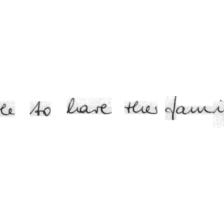

label: normal
predicted: flipped


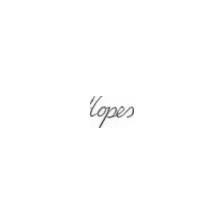

label: flipped
predicted: normal


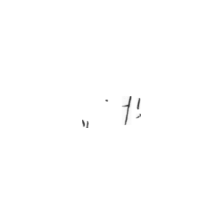

label: flipped
predicted: flipped


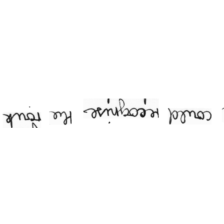

label: flipped
predicted: flipped


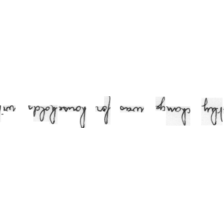

label: flipped
predicted: flipped


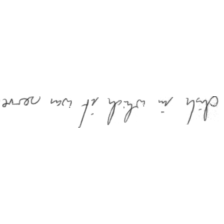

label: flipped
predicted: flipped


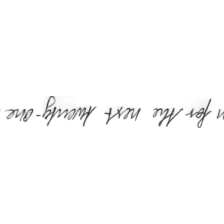

label: normal
predicted: normal


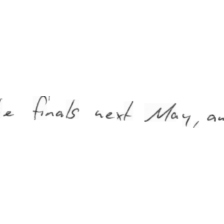

label: normal
predicted: normal


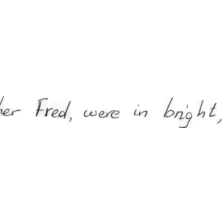

label: flipped
predicted: flipped


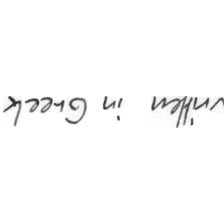

label: flipped
predicted: flipped


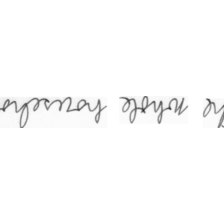

label: flipped
predicted: flipped


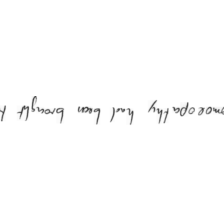

label: flipped
predicted: flipped


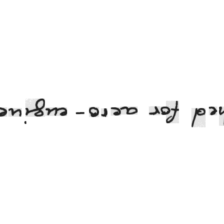

label: normal
predicted: normal


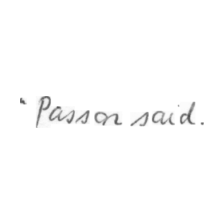

label: normal
predicted: normal


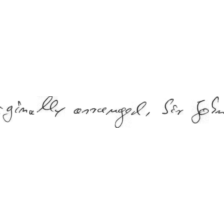

label: flipped
predicted: flipped


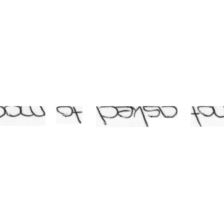

'\nprint(last)\n# print(last.numpy())\n# get element 5618 of train_dl and run it through the model\nmodel.eval() # model does a lot better in eval because of dropout\n\nfor i in range(600, 630):\n  ele, target = train_dl.dataset.__getitem__(i)\n  # run it through model\n  ele, target = ele.to(device), target\n  result = model(ele.unsqueeze(0)).detach().cpu().numpy() # unsqueeze converts it to a 1-batch\n  result = result.argmax(1)\n  print(f"{i}: {result}, {target}")\n  # ele\nmodel.train()\n'

In [25]:

last = None
def peek_trained(dl, model):
    model.eval()
    with torch.no_grad():
        # test it out by taking a peek
        for _ in range(1):
            img1b, lbl = next(iter(dl))
                # img1 = F.to_pil_image(train_set.__getitem__(5)[0])
                # print(img1, lbl)
            print(img1b.shape, lbl.shape)
            for i, _ in enumerate(img1b):
                ele = img1b.to(device)
                result = model(ele).detach().cpu().numpy()
                result = result.argmax(1)

                img1 = F.to_pil_image(img1b[i], mode='RGB') # , mode='L') # grayscale
                # img1.show()
                print(f"label: {'flipped' if lbl[i] else 'normal'}")
                # print(result)
                print(f"predicted: {'flipped' if result[i] else 'normal'}")
                # print(img1b[i])
                display(img1)
                global last
                last = img1b[i]


    model.train()

peek_trained(test_dl, model)
"""
print(last)
# print(last.numpy())
# get element 5618 of train_dl and run it through the model
model.eval() # model does a lot better in eval because of dropout

for i in range(600, 630):
  ele, target = train_dl.dataset.__getitem__(i)
  # run it through model
  ele, target = ele.to(device), target
  result = model(ele.unsqueeze(0)).detach().cpu().numpy() # unsqueeze converts it to a 1-batch
  result = result.argmax(1)
  print(f"{i}: {result}, {target}")
  # ele
model.train()
"""

In [ ]:
print(model)
# get shape of tensor of dataset
print(dataset[0][0].shape)

from torchsummary import summary

# train_dl has torch.Size([4, 3, 32, 256]) with batch_size = 4
summary(model, (1, 32, 128))

In [ ]:
# load model from .pt file
# model = OrientationCNN()
# model.load_state_dict(torch.load('model_scripted.pt'))
# model.eval()
model = torch.jit.load('model_scripted.pt')

In [ ]:
from sklearn.metrics import accuracy_score
from numpy import vstack


# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    loop = tqdm(test_dl)
    loop.set_description(f"Evaluating model")
    for i, (inputs, targets) in enumerate(loop):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [ ]:
evaluate_model(test_dl, model)

  0%|          | 0/419 [00:00<?, ?it/s]

ValueError: Classification metrics can't handle a mix of binary and multiclass-multioutput targets